<h1><center>🐟Fish Classification🔎</center></h1>
<h3><center>🐠(Prediction at the end)🔮</center></h3>
<center><img src= "https://i.pinimg.com/originals/38/e8/f6/38e8f6e7abe5a3267752754694c7a5ec.jpg" alt ="Fish" style='width: 600px;'></center>

<h3>A Large-Scale Dataset for Segmentation and Classification</h3>
<p>

Authors: O. Ulucan, D. Karakaya, M. Turkan
Department of Electrical and Electronics Engineering, Izmir University of Economics, Izmir, Turkey
Corresponding author: M. Turkan
Contact Information: mehmet.turkan@ieu.edu.tr

Paper : A Large-Scale Dataset for Fish Segmentation and Classification
General Introduction

This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
The dataset includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel,
black sea sprat, striped red mullet, trout, shrimp image samples.

</p>

<h3>Purpose of the work</h3>
<p>
    
This dataset was collected in order to carry out segmentation, feature extraction, and classification tasks
and compare the common segmentation, feature extraction, and classification algorithms (Semantic Segmentation, Convolutional Neural Networks, Bag of Features).
All of the experiment results prove the usability of our dataset for purposes mentioned above.

Data Gathering Equipment and Data Augmentation

Images were collected via 2 different cameras, Kodak Easyshare Z650 and Samsung ST60.
Therefore, the resolution of the images are 2832 x 2128, 1024 x 768, respectively.

Before the segmentation, feature extraction, and classification process, the dataset was resized to 590 x 445
by preserving the aspect ratio. After resizing the images, all labels in the dataset were augmented (by flipping and rotating).

At the end of the augmentation process, the number of total images for each class became 2000; 1000 for the RGB fish images
and 1000 for their pair-wise ground truth labels.
</p>

<h3>Description of the dataset</h3>
<p>

The dataset contains 9 different seafood types. For each class, there are 1000 augmented images and their pair-wise augmented ground truths.
Each class can be found in the "Fish_Dataset" file with their ground truth labels. All images for each class are ordered from "00000.png" to "01000.png".

For example, if you want to access the ground truth images of the shrimp in the dataset, the order should be followed is "Fish->Shrimp->Shrimp GT".
    
</p>

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
image_dir = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepaths').astype(str)
labels = pd.Series(labels, name='Labels')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Labels'].apply(lambda x: x[-2:] != 'GT')]

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head()

Filepaths         Labels
0  ../input/a-large-scale-fish-dataset/Fish_Datas...     Red Mullet
1  ../input/a-large-scale-fish-dataset/Fish_Datas...          Trout
2  ../input/a-large-scale-fish-dataset/Fish_Datas...       Sea Bass
3  ../input/a-large-scale-fish-dataset/Fish_Datas...  Red Sea Bream
4  ../input/a-large-scale-fish-dataset/Fish_Datas...          Trout

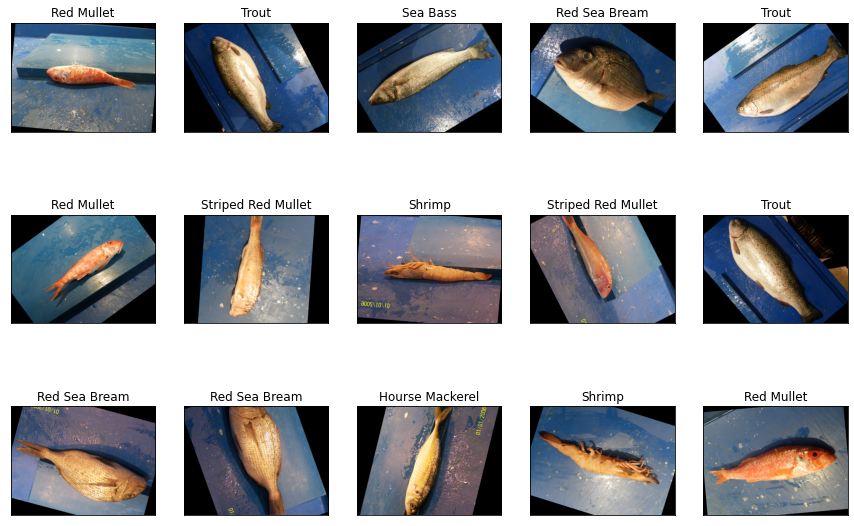

In [3]:
#Displaying a subsample of the dataset
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepaths[i]))
    ax.set_title(image_df.Labels[i])
    
plt.show()

In [4]:
!pip install dataprep
from dataprep.eda import create_report

     |████████████████████████████████| 1.8 MB 843 kB/s 
     |████████████████████████████████| 1.5 MB 33.6 MB/s 
     |████████████████████████████████| 719 kB 39.1 MB/s 
     |████████████████████████████████| 63 kB 2.5 MB/s 
     |████████████████████████████████| 125 kB 64.4 MB/s 
     |████████████████████████████████| 848 kB 51.2 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 743 kB 37.0 MB/s 
  Created wheel for metaphone: filename=Metaphone-0.6-py3-none-any.whl size=13905 sha256=d6dbfe31362f501ccf395ee0c21e402863425c8ac2567a09535e6afa00c9367d
  Stored in directory: /root/.cache/pip/wheels/1d/a8/cb/6f8902aa5457bd71344e00665c230e9c45255b3f57f2194a0f
Successfully built metaphone
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.0.1
    Uninstalling Jinja2-3.0.1:
      Successfully uninstalled Jinja2-3.0.1
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling rege

  0%|          | 0/243 [00:00<?, ?it/s]

DataPrep Report
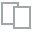
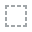
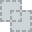
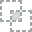
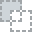
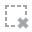
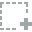
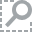
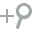
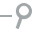
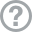
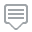
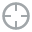
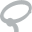
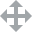
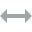
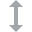
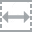
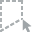
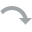
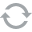
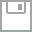
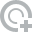
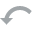
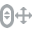
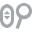
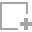
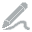
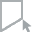
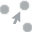
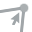
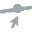

In [5]:
create_report(image_df)

# Modelling

## Creating the model

In [6]:
import tensorflow as tf

In [7]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.85, shuffle=True, random_state=1)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.15
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 6503 validated image filenames belonging to 9 classes.


In [10]:
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 1147 validated image filenames belonging to 9 classes.


In [11]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 1350 validated image filenames belonging to 9 classes.


In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

In [13]:
input_shape = (224, 224, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        9

In [14]:
from tensorflow.keras.optimizers import Adam

In [15]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)

history = model.fit(train_images, validation_data=val_images, epochs=6, callbacks=callback)

Epoch 1/6
102/102 [==============================] - 177s 2s/step - loss: 1.9274 - accuracy: 0.2592 - val_loss: 0.8328 - val_accuracy: 0.7018
Epoch 2/6
102/102 [==============================] - 77s 755ms/step - loss: 0.7174 - accuracy: 0.7444 - val_loss: 0.4143 - val_accuracy: 0.8527
Epoch 3/6
102/102 [==============================] - 77s 760ms/step - loss: 0.2891 - accuracy: 0.9041 - val_loss: 0.2049 - val_accuracy: 0.9294
Epoch 4/6
102/102 [==============================] - 77s 755ms/step - loss: 0.1519 - accuracy: 0.9503 - val_loss: 0.1049 - val_accuracy: 0.9608
Epoch 5/6
102/102 [==============================] - 77s 755ms/step - loss: 0.0732 - accuracy: 0.9751 - val_loss: 0.1196 - val_accuracy: 0.9616
Epoch 6/6
102/102 [==============================] - 77s 752ms/step - loss: 0.0810 - accuracy: 0.9771 - val_loss: 0.1206 - val_accuracy: 0.9599


In [16]:
model.save('1rst-model.h5')

# Visualize the  filters

(1, 111, 111, 64)
(1, 109, 109, 64)
(1, 54, 54, 64)
(1, 52, 52, 32)
(1, 26, 26, 32)
(1, 24, 24, 32)
(1, 12, 12, 32)
(1, 4608)
(1, 512)
(1, 128)
(1, 128)
(1, 128)
(1, 128)
(1, 9)


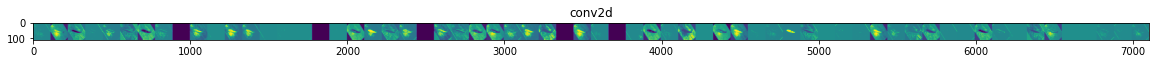

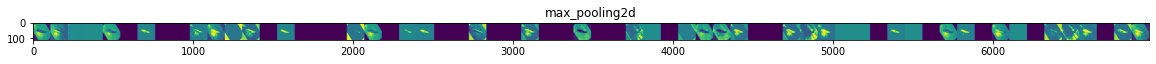

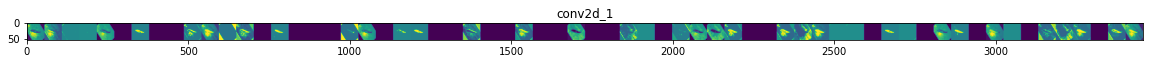

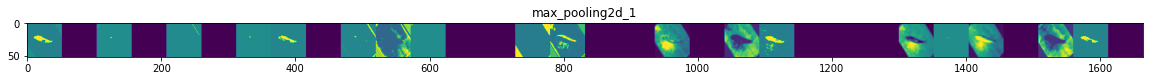

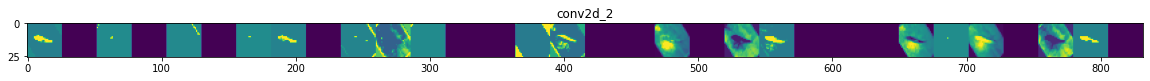

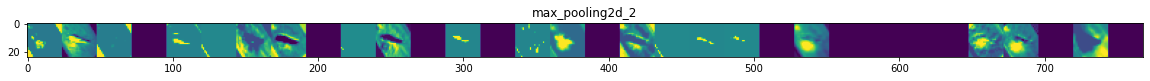

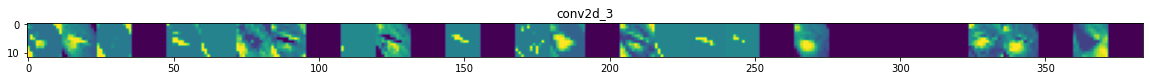

In [17]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img_path=test_df['Filepaths'][5221]
# Define a new Model, Input= image 
# Output= intermediate representations for all layers in the  
# previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
#Load the input image
img = load_img(img_path, target_size=(224, 224))
# Convert ht image to Array of dimension (150,150,3)
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)
# Rescale by 1/255
x /= 255.0
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

## Performances

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

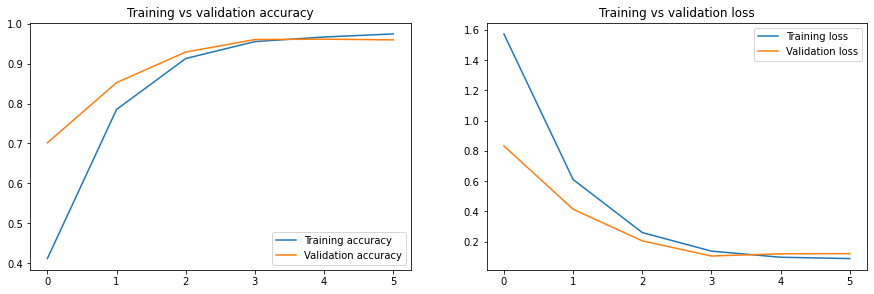

In [19]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [20]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

labels = train_images.class_indices
labels = dict((v,k) for k, v in labels.items())

print(labels)
print(pred)

{0: 'Black Sea Sprat', 1: 'Gilt-Head Bream', 2: 'Hourse Mackerel', 3: 'Red Mullet', 4: 'Red Sea Bream', 5: 'Sea Bass', 6: 'Shrimp', 7: 'Striped Red Mullet', 8: 'Trout'}
[0 0 6 ... 3 3 4]


In [21]:
y_pred = [labels[k] for k in pred]
print(classification_report(test_df.Labels, y_pred))
print('--------------------------------')
print(confusion_matrix(test_df.Labels, y_pred))
print('--------------------------------')

                    precision    recall  f1-score   support

   Black Sea Sprat       0.97      0.99      0.98       150
   Gilt-Head Bream       0.92      0.99      0.95       169
   Hourse Mackerel       0.98      0.99      0.98       135
        Red Mullet       0.99      0.99      0.99       156
     Red Sea Bream       0.99      0.92      0.95       159
          Sea Bass       0.97      0.93      0.95       149
            Shrimp       1.00      0.96      0.98       144
Striped Red Mullet       0.96      0.96      0.96       154
             Trout       0.93      0.96      0.94       134

          accuracy                           0.97      1350
         macro avg       0.97      0.97      0.97      1350
      weighted avg       0.97      0.97      0.97      1350

--------------------------------
[[149   0   0   0   0   1   0   0   0]
 [  0 167   0   0   1   1   0   0   0]
 [  0   1 133   0   1   0   0   0   0]
 [  0   0   0 155   0   0   0   1   0]
 [  0   4   0   0 147   0   

In [22]:
model.evaluate(test_images)[1]

22/22 [==============================] - 14s 617ms/step - loss: 0.1145 - accuracy: 0.9659


0.965925931930542